In [50]:
import pandas as pd
from pathlib import Path


df = pd.read_csv(
    r"E:\Python Project\Spam-Email\Spam-Email-Detection-Classification\data\raw\spam.csv",
    encoding='latin-1')


In [51]:
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [52]:
df.shape


(5572, 2)

In [53]:
df.isnull().sum()


label    0
text     0
dtype: int64

In [54]:
df['label'].value_counts()


label
ham     4825
spam     747
Name: count, dtype: int64

##
EDA

In [55]:
df['text_len'] = df['text'].apply(len)
df[['label', 'text_len']].groupby('label').mean()


,text_len
label,
ham,71.023627
spam,138.866131


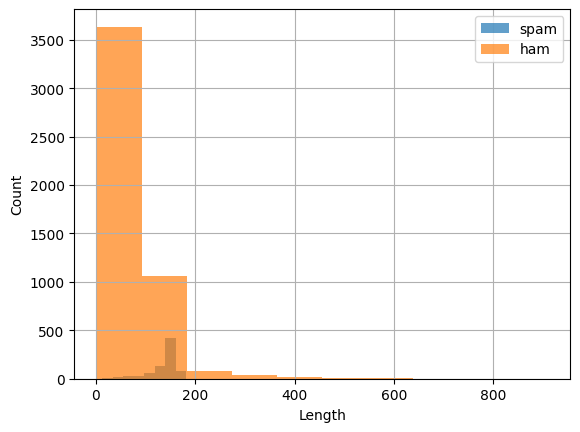

In [56]:
import matplotlib.pyplot as plt

df[df['label']=='spam']['text_len'].hist(alpha=0.7)
df[df['label']=='ham']['text_len'].hist(alpha=0.7)
plt.xlabel("Length")
plt.ylabel("Count")
plt.legend(["spam","ham"])
plt.show()


In [57]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
import sys
sys.executable


'e:\\Python Project\\Spam-Email\\spamenv\\Scripts\\python.exe'

In [59]:
import sys
from pathlib import Path

# مسیر پروژه اصلی
project_path = Path().resolve().parent  # اگه داخل notebooks هستی
# یا Path("E:/Python Project/Spam-Email/Spam-Email-Classification")
sys.path.append(str(project_path))
from src.preprocess import preprocess_text

df['clean_text'] = df['text'].apply(preprocess_text)
df[['text', 'clean_text']].head()


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [60]:
df['clean_text'].str.len().describe()

count    5572.000000
mean       50.470567
std        38.458141
min         0.000000
25%        22.000000
50%        38.000000
75%        74.000000
max       516.000000
Name: clean_text, dtype: float64

In [61]:
from src.features import create_tfidf_features

X, vectorizer = create_tfidf_features(df['clean_text'])
y = df['label']

X.shape


(5572, 3000)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [63]:
'''from src.train import train_model, evaluate_model

model = train_model(X_train, y_train)

acc, report = evaluate_model(model, X_test, y_test)

print("Accuracy:", acc)
print(report)'''

'from src.train import train_model, evaluate_model\n\nmodel = train_model(X_train, y_train)\n\nacc, report = evaluate_model(model, X_test, y_test)\n\nprint("Accuracy:", acc)\nprint(report)'

In [64]:
'''from src.train import cross_validate_model

scores = cross_validate_model(X, y, cv=5)
scores, scores.mean()'''


'from src.train import cross_validate_model\n\nscores = cross_validate_model(X, y, cv=5)\nscores, scores.mean()'

Hyperparameter Tuning

In [65]:
from src.train import tune_hyperparameters ,evaluate_model

best_model, best_params, best_score = tune_hyperparameters(X_train, y_train)

best_params, best_score


Fitting 5 folds for each of 10 candidates, totalling 50 fits


e:\Python Project\Spam-Email\spamenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


({'C': 10, 'penalty': 'l2', 'solver': 'liblinear'},
 np.float64(0.9567489794371188))

In [66]:
acc, report = evaluate_model(best_model, X_test, y_test)
print(acc)
print(report)


0.9856502242152466
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.97      0.93      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [67]:
from src.save_load import save_model

save_model(best_model, vectorizer)


In [68]:
from src.save_load import load_model
from src.preprocess import preprocess_text

model, vectorizer = load_model()

sample_text = "Hey, are we still meeting tomorrow at 5 pm? Let me know."
clean = preprocess_text(sample_text)
vec = vectorizer.transform([clean])

prediction = model.predict(vec)
prediction


array(['ham'], dtype=object)

In [69]:
model.predict_proba(vec)


array([[0.99770009, 0.00229991]])

In [70]:
model.classes_


array(['ham', 'spam'], dtype=object)

In [71]:
print(model.predict(vec))
print(model.predict_proba(vec))
print(model.classes_)


['ham']
[[0.99770009 0.00229991]]
['ham' 'spam']


# Confusion Matrix

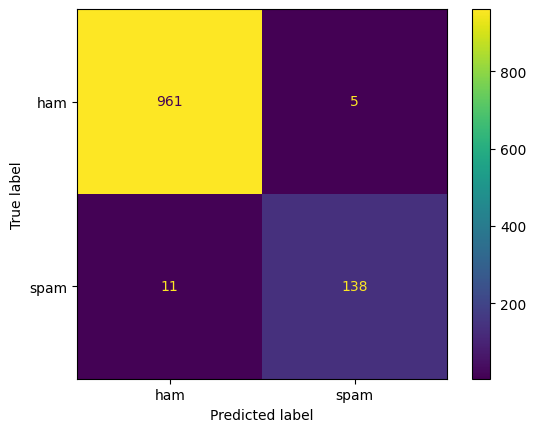

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
disp.plot()


# ROC Curve + AUC

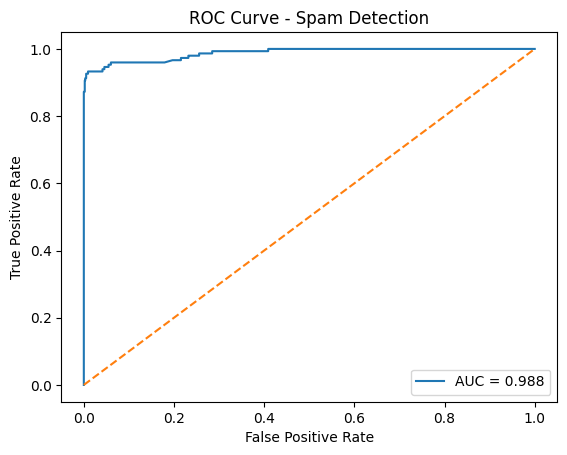

In [79]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label='spam')
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Spam Detection")
plt.legend()
plt.show()


##
The model achieves an AUC of 0.988, indicating excellent separability between spam and ham messages. The ROC curve shows strong performance with low false positive rates, making it suitable for real-world spam filtering.